#### <h1><center>CMSC 478: Introduction to Machine Learning</center></h1>

<center><img src="img/title.jpg" align="center"/></center>


<h3 style="color:blue;"><center>Instructor: Fereydoon Vafaei</center></h3>


<h5 style="color:purple;"><center>Training Deep Neural Networks</center></h5>

<h1><center>Agenda</center></h1>

- <b>Training Deep Neural Networks</b>
    - Vanishing and Exploding Gradients
    - Glorot and He initialization
    - Dying Neurons
    - Nonsaturating Activation Functions
        - Leaky ReLU
        - ELU
        - SELU
    - Batch Normalization
    - Gradient Clipping
    - Transfer Learning
    - Unsupervised Pretraining
    - Momentum Optimization and Faster Optimizers
    - Learning Rate Scheduling
    - Regularization and Dropout

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
from tensorflow import keras

<h1><center>Challenges of Training DNNs</center></h1>

- So far, you have seen shallow nets, with just a few hidden layers. What if you need to tackle a complex problem, such as detecting hundreds of types of objects in high-resolution images? You may need to train a much deeper DNN, perhaps with 10 layers or many more, each containing hundreds of neurons, linked by hundreds of thousands of connections. Training a deep DNN isn’t a walk in the park!

- Here are some of the problems you could run into:
    - You may be faced with the tricky vanishing gradients problem or the related exploding gradients problem. This is when the gradients grow smaller and smaller, or larger and larger, when flowing backward through the DNN during training. Both of these problems make lower layers very hard to train.
    - You might not have enough training data for such a large network, or it might be too costly to label.
    - Training may be extremely slow.
    - A model with millions of parameters would severely risk overfitting the training set, especially if there are not enough training instances or if they are too noisy.
    
- We'll study some techniques and approaches to tackle these problems so you will be able to train very deep nets. **Welcome to Deep Learning!**

<h1><center>Vanishing and Exploding Gradients</center></h1>

- During training DNNs, gradients often get smaller and smaller as the algorithm progresses down to the lower layers.

- As a result, the Gradient Descent update leaves the lower layers’ connection weights virtually unchanged, and training never converges to a good solution. This is called the **vanishing gradients** problem.

- In some cases, the opposite can happen: the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges. This is the **exploding gradients** problem, which surfaces in **Recurrent Neural Networks (RNN)**.

- More generally, DNNs suffer from **unstable gradients**; different layers may learn at widely different speeds.

<h1><center>Logistic Function Saturation</center></h1>

- Looking at the logistic activation function (see Figure 11-1), you can see that when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0.

- Thus, when backpropagation kicks in it has virtually no gradient to propagate back through the network; and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

<center><img src="img/saturation.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Glorot and He Initialization</center></h1>

- In their paper, Glorot and Bengio propose a way to significantly alleviate the unstable gradients problem.

- They point out that we need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients.

- We don’t want the signal to die out, nor do we want it to explode and saturate.

- For the signal to flow properly, the authors argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we need the gradients to have equal variance before and after flowing through a layer in the reverse direction.

- It is actually not possible to guarantee both unless the layer has an equal number of inputs and neurons (these numbers are called the **fan-in** and **fan-out** of the layer), but Glorot and Bengio proposed a good compromise that has proven to work very well in practice.

<h1><center>Glorot and He Initialization Equations</center></h1>

- The connection weights of each layer must be initialized randomly as described in Equation 11-1, where $fan_{in}$ is the number of inputs of the layer and $fan_{out}$ is the number of neurons of the layer and 
$fan_{avg} = (fan_{in} + fan_{out})/2$.


- This initialization strategy is called **Xavier initialization** or **Glorot initialization**, after the paper’s first author.

<center><img src="img/glorot.png" align="center"/></center>

<h1><center>Initialization Parameters</center></h1>

- If you replace $fan_{avg}$ with $fan_{in}$ in Equation 11-1, you get an initialization strategy that Yann LeCun proposed in the 1990s. He called it **LeCun** initialization.

- Some papers have provided similar strategies for different activation functions.

- These strategies differ only by the scale of the variance and whether they use $fan_{avg}$ or $fan_{in}$

<center><img src="img/init.png" align="center"/></center>

<font size='1'>Table from Ref[1]</font>

<h1><center>Initialization in Keras</center></h1>

- By default, Keras uses **Glorot** initialization with a uniform distribution.

- When creating a layer in Keras, you can change **Glorot** initialization with a uniform distribution (which is the default) to **He** initialization by setting `kernel_initializer="he_uniform"` or `kernel_initializer="he_normal"` like this:

In [3]:
# Example of changing the initialization method
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

- If you want **He** initialization with a uniform distribution but based on `fan_avg` rather than `fan_in`, you can use the `VarianceScaling` initializer like this:

In [ ]:
# Example of changing the parameters of the initialization method
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

In [3]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

<h1><center>Dying Neurons and Nonsaturating Activation Functions</center></h1>

- One of the insights in the 2010 paper by Glorot and Bengio was that the problems with unstable gradients were in part due to a poor choice of activation function.

- Until then most people had assumed that if Mother Nature had chosen to use roughly sigmoid activation functions in biological neurons, they must be an excellent choice. But it turns out that other activation functions behave much better in deep neural networks—in particular, the ReLU activation function, mostly because it does not saturate for positive values (and because it is fast to compute).

- The ReLU activation function is not perfect, however. It suffers from a problem known as the **dying ReLUs** (aka **dying neurons**): during training, some neurons effectively “die,” meaning they stop outputting anything other than 0.

- In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate.

- A neuron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set. When this happens, it just keeps outputting zeros, and Gradient Descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative.

<h1><center>Leaky ReLU</center></h1>

- To solve **dying neurons** problem, you may want to use a variant of the ReLU function, such as the **leaky ReLU**.

[-5, 5, -0.5, 4.2]

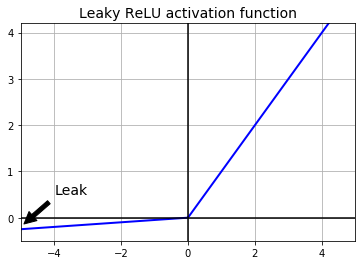

In [3]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)
z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

<h1><center>ELU</center></h1>

- A 2015 paper by Djork-Arné Clevert et al. proposed a new activation function called the **Exponential Linear Unit (ELU)** that outperformed all the ReLU variants in the authors’ experiments: training time was reduced, and the neural network performed better on the test set.

- The following code graphs the function, and Equation 11-2 shows its definition.

**Equation 11-2: ELU activation function**

$
\operatorname{ELU}_\alpha(z) =
\begin{cases}
\alpha(\exp(z) - 1) & \text{if } z < 0\\
z & if z \ge 0
\end{cases}
$

[-5, 5, -2.2, 3.2]

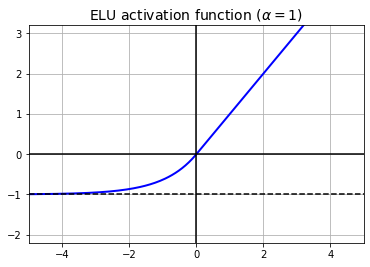

In [7]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

<h1><center>ELU Properties</center></h1>

- The ELU activation function looks a lot like the ReLU function, with a few major differences:

    - ELU takes on negative values when z < 0, which allows the unit to have an average output closer to 0 and helps alleviate the **vanishing gradients** problem.
        - The hyperparameter α defines the value that the ELU function approaches when z is a large negative number.
        - It is usually set to 1, but you can tweak it like any other hyperparameter.

    - It has a nonzero gradient for z < 0, which avoids the **dead neurons** problem.

    - If α is equal to 1 then the function is smooth everywhere, including around z = 0, which helps speed up Gradient Descent since it does not bounce as much to the left and right of z = 0.

- The main drawback of the ELU activation function is that it is slower to compute than the ReLU function and its variants (due to the use of the exponential function).

- Its faster convergence rate during training compensates for that slow computation, but still, at test time an ELU network will be generally slower than a ReLU network.

<h1><center> Scaled ELU - SELU</center></h1>

- SELU is a scaled variant of the ELU activation function.

- The authors showed that if you build a neural network composed exclusively of a stack of dense layers, and if all hidden layers use the SELU activation function, then the network will self-normalize: the output of each layer will tend to preserve a mean of 0 and standard deviation of 1 during training, which solves the **vanishing/exploding gradients** problem.

- As a result, the SELU activation function often significantly outperforms other activation functions for such neural nets (especially deep ones).

In [8]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

[-5, 5, -2.2, 3.2]

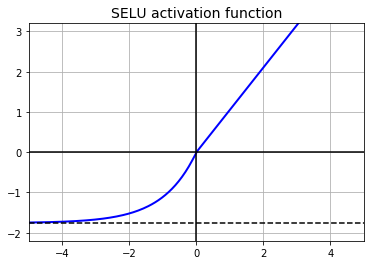

In [9]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

<h1><center>SELU Conditions</center></h1>

- There are a few conditions for self-normalization of SELU to happen:
    - The input features must be standardized (mean 0 and standard deviation 1).
    
    - Every hidden layer’s weights must be initialized with LeCun normal initialization. In Keras, this means setting `kernel_initializer="lecun_normal"`.
    
    - The network’s architecture must be sequential.
    
    - If you try to use SELU in nonsequential architectures, such as RNNs or networks with skip connections (i.e., connections that skip layers, such as in Wide & Deep nets), self-normalization will not be guaranteed, so SELU will not necessarily outperform other activation functions.
    
    - The paper only guarantees self-normalization if all layers are dense, but some researchers have noted that the SELU activation function can improve performance in Convolutional Neural Nets (CNNs) as well

In [4]:
# Activation functions in keras
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

<h1><center>Batch Normalization</center></h1>

- Although using **He** initialization along with ELU (or any variant of ReLU) can significantly reduce the danger of the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training.

- In a 2015 paper, Sergey Ioffe and Christian Szegedy proposed a technique called **Batch Normalization (BN)** that addresses these problems.

- The technique consists of adding an operation in the model just before or after the activation function of each hidden layer. This operation simply zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting.

- In other words, the operation lets the model learn the optimal scale and mean of each of the layer’s inputs.

- In many cases, if you add a BN layer as the very first layer of your neural network, you do not need to standardize your training set (e.g., using a `StandardScaler`); the BN layer will do it for you (well, approximately, since it only looks at one batch at a time, and it can also rescale and shift each input feature).

- So during training, BN standardizes its inputs, then rescales and offsets them.

- Batch normalization makes your hyperparameter search problem much easier, and makes your neural network much more robust. The choice of hyperparameters is a much bigger range of hyperparameters that work well, and will also enable you to much more easily train even very deep networks.

<h1><center>Batch Normalization Algorithm</center></h1>

- In order to zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation.

- It does so by evaluating the mean and standard deviation of the input over the current mini-batch, hence the name **"Batch Normalization"**.

- The whole operation is summarized step by step in Equation 11-3.

**Equation 11-3: Batch Normalization algorithm** 

$
\begin{split}
1.\quad & \mathbf{\mu}_B = \dfrac{1}{m_B}\sum\limits_{i=1}^{m_B}{\mathbf{x}^{(i)}}\\
2.\quad & {\mathbf{\sigma}_B}^2 = \dfrac{1}{m_B}\sum\limits_{i=1}^{m_B}{(\mathbf{x}^{(i)} - \mathbf{\mu}_B)^2}\\
3.\quad & \hat{\mathbf{x}}^{(i)} = \dfrac{\mathbf{x}^{(i)} - \mathbf{\mu}_B}{\sqrt{{\mathbf{\sigma}_B}^2 + \epsilon}}\\
4.\quad & \mathbf{z}^{(i)} = \gamma ⊗ \hat{\mathbf{x}}^{(i)} + \mathbf{β}
\end{split}
$

- In Batch Normalization algorithm:
    - $μ_B$ is the vector of input means, evaluated over the whole mini-batch $B$ (it contains one mean per input).

    - $σ_B$ is the vector of input standard deviations, also evaluated over the whole mini-batch (it contains one standard deviation per input).

    - $m_B$ is the number of instances in the mini-batch.

    - $\hat{\mathbf{x}}^{(i)}$ is the vector of zero-centered and normalized inputs for instance $i$.

    - $γ$ is the output scale parameter vector for the layer (it contains one scale parameter per input).

    - $⊗$ represents element-wise multiplication (each input is multiplied by its corresponding output scale parameter).

    - $\mathbf{β}$ is the output shift (offset) parameter vector for the layer (it contains one offset parameter per input). Each input is offset by its corresponding shift parameter.

    - $\epsilon$ is a tiny number that avoids division by zero typically $10^{–5}$. This is called a **smoothing term**.

    - $\mathbf{z}^{(i)}$ is the output of the BN operation. It is a rescaled and shifted version of the inputs.

<h1><center>Batch Normalization in Training and Testing</center></h1>

- So during training, BN standardizes its inputs, then rescales and offsets them. What about at test time? Well, it’s not that simple.

- Indeed, we may need to make predictions for individual instances rather than for batches of instances: in this case, we will have no way to compute each input’s mean and standard deviation.

- Moreover, even if we do have a batch of instances, it may be too small, or the instances may not be independent and identically distributed, so computing statistics over the batch instances would be unreliable.

- One solution could be to wait until the end of training, then run the whole training set through the neural network and compute the mean and standard deviation of each input of the BN layer.

- These **"final"** input means and standard deviations could then be used instead of the batch input means and standard deviations when making predictions.

- However, most implementations of Batch Normalization estimate these final statistics during training by using a moving average of the layer’s input means and standard deviations.

<h1><center>Implementing Batch Normalization with Keras</center></h1>

- Keras does the BN calculations automatically when you use the `BatchNormalization` layer. To sum up, four parameter vectors are learned in each batch-normalized layer:

    - $γ$ (the output scale vector) and $\mathbf{β}$ (the output offset vector) are learned through regular backpropagation.
    - $μ$ (the final input mean vector) and $σ$ (the final input standard deviation vector) are estimated using an exponential moving average.

- Note that $μ$ and $σ$ are estimated during training, but they are used only after training (to replace the batch input means and standard deviations in Equation 11-3).

- Ioffe and Szegedy demonstrated that Batch Normalization considerably improved all the deep neural networks they experimented with, leading to a huge improvement in the ImageNet classification task (ImageNet is a large database of images classified into many classes, commonly used to evaluate computer vision systems).

- The vanishing gradients problem was strongly reduced, to the point that they could use saturating activation functions such as the tanh and even the logistic activation function.

- The networks were also much less sensitive to the weight initialization. The authors were able to use much larger learning rates, significantly speeding up the learning process.

- Finally, Batch Normalization acts like a regularizer, reducing the need for other regularization techniques.

- Batch Normalization does, however, add some complexity to the model although it can remove the need for normalizing the input data.

<h1><center>Implementing Batch Normalization with Keras</center></h1>

- As with most things with Keras, implementing Batch Normalization is simple and intuitive. Just add a `BatchNormalization` layer before or after each hidden layer’s activation function, and optionally add a BN layer as well as the first layer in your model.

- For example, this model applies BN after every hidden layer and as the first layer in the model (after flattening the input images):

In [5]:

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

<h1><center>Batch Normalization with Keras - Trainable vs Non-trainable Parameters</center></h1>

- As you can see, each BN layer adds four parameters per input: $γ$, $\mathbf{β}$, $μ$, and $σ$ (for example, the first BN layer adds 3,136 parameters, which is 4 × 784).

- The last two parameters, $μ$ and $σ$, are the moving averages; they are not affected by backpropagation, so Keras calls them **"non-trainable"**.

- However, they are estimated during training, based on the training data, so arguably they are trainable. In Keras, **"non-trainable"** really means "*untouched by backpropagation*".

- If you count the total number of BN parameters, 3,136 + 1,200 + 400, and divide by 2, you get 2,368, which is the total number of non-trainable parameters in this model.

- Let’s look at the parameters of the first BN layer. Two are trainable (by backpropagation), and two are not:

In [8]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

- Now when you create a BN layer in Keras, it also creates two operations that will be called by Keras at each iteration during training. These operations will update the moving averages.

- Since we are using the TensorFlow backend, these operations are **TensorFlow operations**, and you can see them by running the following:

In [10]:
model.layers[1].updates

<h1><center>Batch Normalization with Keras - Using BN Before Activation Functions</center></h1>

- The authors of the BN paper argued in favor of adding the BN layers before the activation functions, rather than after (as we just did).

- There is some debate about this, as which is preferable seems to depend on the task---you can experiment with this too to see which option works best on your dataset.

- To add the BN layers before the activation functions, you must remove the activation function from the hidden layers and add them as separate layers after the BN layers.

- Moreover, since a Batch Normalization layer includes one offset parameter per input, you can remove the bias term from the previous layer (just pass `use_bias=False` when creating it):

In [11]:
model = keras.models.Sequential([
keras.layers.Flatten(input_shape=[28, 28]),
keras.layers.BatchNormalization(),
keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
keras.layers.BatchNormalization(),
keras.layers.Activation("elu"),
keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
keras.layers.BatchNormalization(),
keras.layers.Activation("elu"),
keras.layers.Dense(10, activation="softmax")
])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30000     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)              

<h1><center>Gradient Clipping</center></h1>

- Another popular technique to mitigate the **exploding gradients** problem is to clip the gradients during backpropagation so that they never exceed some threshold. This is called **Gradient Clipping**.

- This technique is most often used in recurrent neural networks RNNs, as **Batch Normalization** is tricky to use in RNNs.

- For other types of networks, BN is usually sufficient.

<center><img src="img/gradient-clipping.png" align="center"/></center>

- In Keras, implementing Gradient Clipping is just a matter of setting the `clipvalue` or `clipnorm` argument when creating an optimizer, like this:

In [ ]:
# All Keras optimizers accept clipnorm or clipvalue arguments:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="mse", optimizer=optimizer)

optimizer = keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="mse", optimizer=optimizer)

<h1><center>clipnorm vs clipvalue</center></h1>

- This optimizer `keras.optimizers.SGD(clipvalue=1.0)` will clip every component of the gradient vector to a value between –1.0 and 1.0.

- This means that all the partial derivatives of the loss (with regard to each and every trainable parameter) will be clipped between –1.0 and 1.0.

- The threshold is a hyperparameter you can tune.

- Note that it may change the orientation of the gradient vector. For instance, if the original gradient vector is [0.9, 100.0], it points mostly in the direction of the second axis; but once you clip it by value, you get [0.9, 1.0], which points roughly in the diagonal between the two axes.

- In practice, this approach works well. If you want to ensure that Gradient Clipping does not change the direction of the gradient vector, you should clip by norm by setting `clipnorm` instead of `clipvalue`. This will clip the whole gradient if its $l_2$ norm is greater than the threshold you picked.

- For example, if you set `clipnorm=1.0`, then the vector [0.9, 100.0] will be clipped to [0.00899964, 0.9999595], preserving its orientation but almost eliminating the first component.

- If you observe that the gradients explode during training (you can track the size of the gradients using TensorBoard), you may want to try both clipping by value and clipping by norm, with different thresholds, and see which option performs best on the validation set.

<h1><center>Transfer Learning - Reusing Pretrained Layers</center></h1>

- It is generally not a good idea to train a very large DNN from scratch: instead, you should always try to find an existing neural network that accomplishes a similar task to the one you are trying to tackle, then reuse the lower layers of this network. This technique is called **transfer learning**.

- It will not only speed up training considerably, but also require significantly less training data.

- Suppose you have access to a DNN that was trained to classify pictures into 100 different categories, including animals, plants, vehicles, and everyday objects. You now want to train a DNN to classify specific types of vehicles. These tasks are very similar, even partly overlapping, so you should try to reuse parts of the first network (Figure 11-4).

<center><img src="img/transfer-learning.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Transfer Learning</center></h1>

- If the input pictures of your new task don’t have the same size as the ones used in the original task, you will usually have to add a preprocessing step to resize them to the size expected by the original model.

- More generally, transfer learning will work best when the inputs have similar low-level features.

- The output layer of the original model should usually be replaced because it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task.

- Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. You want to find the right number of layers to reuse.

- The more similar the tasks are, the more layers you want to reuse (starting with the lower layers). For very similar tasks, try keeping all the hidden layers and just replacing the output layer.

- It turns out that transfer learning does not work very well with small dense networks, presumably because small networks learn few patterns, and dense networks learn very specific patterns, which are unlikely to be useful in other tasks.

- Transfer learning works best with deep **Convolutional Neural Networks**, which tend to learn feature detectors that are much more general especially in the lower layers.

<h1><center>Transfer Learning with Keras</center></h1>

- Let’s look at an example of **Transfer Learning** in Keras. Suppose the Fashion MNIST dataset only contained eight classes—for example, all the classes except for sandal and shirt. Someone built and trained a Keras model on that set and got reasonably good performance (>90% accuracy). Let’s call this **model A**.

- You now want to tackle a different task: you have images of sandals and shirts, and you want to train a binary classifier (positive=shirt, negative=sandal). Your dataset is quite small; you only have 200 labeled images.

- When you train a new model for this task (let’s call it **model B**) with the same architecture as **model A**, it performs reasonably well (97.2% accuracy). But since it’s a much easier task (there are just two classes), you were hoping for more.

- While drinking your morning coffee, you realize that your task is quite similar to task A, so perhaps transfer learning can help? Let’s find out!

- First, you need to load **model A** and create a new model based on that model’s layers. Let’s reuse all the layers except for the output layer:

In [ ]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

<h1><center>Transfer Learning with Keras Cont.</center></h1>

- Note that `model_A` and `model_B_on_A` now share some layers.

- When you train `model_B_on_A`, it will also affect `model_A`. If you want to avoid that, you need to clone `model_A` before you reuse its layers.

- To do this, you clone model A’s architecture with `clone.model()`, then copy its weights since `clone_model()` does not clone the weights:

In [ ]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

<h1><center>Transfer Learning with Keras Cont.</center></h1>

- Now you could train `model_B_on_A` for task B, but since the new output layer was initialized randomly it will make large errors (at least during the first few epochs), so there will be large error gradients that may wreck the reused weights. To avoid this, one approach is to freeze the reused layers during the first few epochs, giving the new layer some time to learn reasonable weights. To do this, set every layer’s `trainable` attribute to `False` and compile the model:

In [ ]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False
model_B_on_A.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])

- You must always compile your model after you freeze or unfreeze layers.

<h1><center>Transfer Learning with Keras Cont.</center></h1>

- Now you can train the model for a few epochs, then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task B.

- After unfreezing the reused layers, it is usually a good idea to reduce the learning rate, once again to avoid damaging the reused weights:

In [ ]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4, validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True
optimizer = keras.optimizers.SGD(lr=1e-4) # the default lr is 1e-2
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16, validation_data=(X_valid_B, y_valid_B))

<h1><center>Unsupervised Pretraining</center></h1>

- Suppose you want to tackle a complex task for which you don’t have much labeled training data, but unfortunately you cannot find a model trained on a similar task.

- First, you should try to gather more labeled training data, but if you can’t, you may still be able to perform unsupervised pretraining.

- Indeed, it is often cheap to gather unlabeled training examples, but expensive to label them.

- If you can gather plenty of unlabeled training data, you can try to use it to train an unsupervised model, such as an autoencoder or a generative adversarial network.

- Then you can reuse the lower layers of the autoencoder or the lower layers of the GAN’s discriminator, add the output layer for your task on top, and fine-tune the final network using supervised learning (i.e., with the labeled training examples).

- It is this technique that Geoffrey Hinton and his team used in 2006 and which led to the revival of neural networks and the success of Deep Learning.

- Until 2010, unsupervised pretraining—typically with restricted Boltzmann machines (RBMs)—was the norm for deep nets, and only after the vanishing gradients problem was alleviated did it become much more common to train DNNs purely using supervised learning.

- Unsupervised pretraining (today typically using autoencoders or GANs rather than RBMs) is still a good option when you have a complex task to solve, no similar model you can reuse, and little labeled training data but plenty of unlabeled training data.

<h1><center>Unsupervised Pretraining</center></h1>

- Note that in the early days of Deep Learning it was difficult to train deep models, so people would use a technique called greedy layer-wise pretraining (depicted in Figure 11-5). They would first train an unsupervised model with a single layer, typically an RBM, then they would freeze that layer and add another one on top of it, then train the model again (effectively just training the new layer), then freeze the new layer and add another layer on top of it, train the model again, and so on.

- Nowadays, things are much simpler: people generally train the full unsupervised model in one shot (i.e., in Figure 11-5, just start directly at step three) and use autoencoders or GANs rather than RBMs.

<center><img src="img/unsupervised-pretraining.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Pretraining on an Auxiliary Task</center></h1>

- If you do not have much labeled training data, one last option is to train a first neural network on an auxiliary task for which you can easily obtain or generate labeled training data, then reuse the lower layers of that network for your actual task.

- The first neural network’s lower layers will learn feature detectors that will likely be reusable by the second neural network.

- For example, if you want to build a system to recognize faces, you may only have a few pictures of each individual—clearly not enough to train a good classifier. Gathering hundreds of pictures of each person would not be practical. You could, however, gather a lot of pictures of random people on the web and train a first neural network to detect whether or not two different pictures feature the same person.

- Such a network would learn good feature detectors for faces, so reusing its lower layers would allow you to train a good face classifier that uses little training data.

- For natural language processing (NLP) applications, you can download a corpus of millions of text documents and automatically generate labeled data from it.

- For example, you could randomly mask out some words and train a model to predict what the missing words are e.g., it should predict that the missing word in the sentence “What ___ you saying?” is probably “are” or “were”.

- If you can train a model to reach good performance on this task, then it will already know quite a lot about language, and you can certainly reuse it for your actual task and fine-tune it on your labeled data.


<h1><center>Self-Supervised Learning</center></h1>

- Self-supervised learning is when you automatically generate the labels from the data itself, then you train a model on the resulting **labeled** dataset using supervised learning techniques.

- Since this approach requires no human labeling whatsoever, it is best classified as a form of unsupervised learning.

<h1><center>Momentum Optimization</center></h1>

- Training a very large deep neural network can be painfully slow. So far we have seen four ways to speed up training and reach a better solution:
    - applying a good initialization strategy for the connection weights
    - using a good activation function
    - using Batch Normalization
    - reusing parts of a pretrained network possibly built on an auxiliary task or using unsupervised learning.

- Another huge speed boost comes from using a faster optimizer than the regular Gradient Descent optimizer.

- Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity (if there is some friction or air resistance).

- This is the very simple idea behind **momentum optimization**, proposed by Boris Polyak in 1964.

- In contrast, regular Gradient Descent will simply take small, regular steps down the slope, so the algorithm will take much more time to reach the bottom.

<h1><center>Momentum Optimization Cont.</center></h1>

- Recall that Gradient Descent updates the weights $\mathbf{θ}$ by directly subtracting the gradient of the cost function $J(\mathbf{θ})$ with regard to the weights $(∇_θ J(\mathbf{θ}))$ multiplied by the learning rate $η$.

- The equation is: $\mathbf{θ} ← \mathbf{θ} - η∇_θ J(\mathbf{θ})$.

- It does not care about what the earlier gradients were. If the local gradient is tiny, it goes very slowly.

<h1><center>Momentum Optimization Cont.</center></h1>

- Momentum optimization cares a great deal about what previous gradients were: at each iteration, it subtracts the local gradient from the momentum vector $\mathbf{m}$ multiplied by the learning rate $η$, and it updates the weights by adding this momentum vector (see Equation 11-4).

- In other words, the gradient is used for acceleration, not for speed. To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter $\beta$, called the **momentum**, which must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9.

**Equation 11-4: Momentum algorithm**

1. $\mathbf{m} \gets \beta \mathbf{m} - \eta \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta})$
2. $\boldsymbol{\theta} \gets \boldsymbol{\theta} + \mathbf{m}$

<h1><center>Momentum Optimization Cont.</center></h1>

- You can easily verify that if the gradient remains constant, the terminal velocity (i.e., the maximum size of the weight updates) is equal to that gradient multiplied by the learning rate $η$ multiplied by $1/(1–\beta)$ (ignoring the sign).

- For example, if $\beta = 0.9$, then the terminal velocity is equal to 10 times the gradient times the learning rate, so momentum optimization ends up going 10 times faster than Gradient Descent!

- This allows momentum optimization to escape from plateaus much faster than Gradient Descent.

- When the inputs have very different scales, the cost function will look like an elongated bowl. Gradient Descent goes down the steep slope quite fast, but then it takes a very long time to go down the valley.

- In contrast, momentum optimization will roll down the valley faster and faster until it reaches the bottom (the optimum).

- In deep neural networks that don’t use Batch Normalization, the upper layers will often end up having inputs with very different scales, so using momentum optimization helps a lot.

- It can also help roll past local optima.

- Due to the momentum, the optimizer may overshoot a bit, then come back, overshoot again, and oscillate like this many times before stabilizing at the minimum. This is one of the reasons it’s good to have a bit of friction in the system: it gets rid of these oscillations and thus speeds up convergence.

<h1><center>Momentum Optimization with Keras</center></h1>

- Implementing momentum optimization in Keras is a no-brainer: just use the SGD optimizer and set its momentum hyperparameter:

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

- The one drawback of momentum optimization is that it adds yet another hyperparameter to tune. However, the momentum value of 0.9 usually works well in practice and almost always goes faster than regular Gradient Descent.

<h1><center>Nesterov Accelerated Gradient</center></h1>

- One small variant to momentum optimization, proposed by Yurii Nesterov in 1983, is almost always faster than vanilla momentum optimization.

- The Nesterov Accelerated Gradient (NAG) method, also known as Nesterov momentum optimization, measures the gradient of the cost function not at the local position $\boldsymbol{\theta}$ but slightly ahead in the direction of the momentum, at $\boldsymbol{\theta} + \beta \mathbf{m}$ (see Equation 11-5).

**Equation 11-5: Nesterov Accelerated Gradient algorithm**

1. $\mathbf{m} \gets \beta \mathbf{m} - \eta \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta} + \beta \mathbf{m})$
2. $\boldsymbol{\theta} \gets \boldsymbol{\theta} + \mathbf{m}$

<h1><center>NAG</center></h1>

- This small tweak works because in general the momentum vector will be pointing in the right direction (i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than the gradient at the original position, as you can see in Figure 11-6 where $∇_1$ represents the gradient of the cost function measured at the starting point $\boldsymbol{\theta}$, and $∇_2$ represents the gradient at the point located at $\boldsymbol{\theta} + \beta \mathbf{m}$

- As you can see, the Nesterov update ends up slightly closer to the optimum. After a while, these small improvements add up and NAG ends up being significantly faster than regular momentum optimization.

- Moreover, note that when the momentum pushes the weights across a valley, $∇_1$ continues to push farther across the valley, while $∇_2$ pushes back toward the bottom of the valley. This helps reduce oscillations and thus NAG converges faster.

<center><img src="img/momentum.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>NAG with Keras</center></h1>

- NAG is generally faster than regular momentum optimization. To use it, simply set `nesterov=True` when creating the SGD optimizer:

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

<h1><center>AdaGrad</center></h1>

- Consider the elongated bowl problem again: Gradient Descent starts by quickly going down the steepest slope, which does not point straight toward the global optimum, then it very slowly goes down to the bottom of the valley. It would be nice if the algorithm could correct its direction earlier to point a bit more toward the global optimum.

- The **AdaGrad** algorithm achieves this correction by scaling down the gradient vector along the steepest dimensions (see Equation 11-6).

**Equation 11-6: AdaGrad algorithm**

1. $\mathbf{s} \gets \mathbf{s} + \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta}) \otimes \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta})$
2. $\boldsymbol{\theta} \gets \boldsymbol{\theta} - \eta \, \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta}) \oslash {\sqrt{\mathbf{s} + \epsilon}}$

- The first step accumulates the square of the gradients into the vector $\mathbf{s}$ (recall that the $\otimes$ symbol represents the element-wise multiplication). This vectorized form is equivalent to computing $s_i ← s_i + (∂ J(\boldsymbol{\theta}) / ∂ \theta_i)^2$ for each element $s_i$ of the vector $\mathbf{s}$; in other words, each $s_i$ accumulates the squares of the partial derivative of the cost function with regard to parameter $\theta_i$ .

- If the cost function is steep along the $i^{th}$ dimension, then $s_i$ will get larger and larger at each iteration.

- The second step is almost identical to Gradient Descent, but with one big difference: the gradient vector is scaled down by a factor of $\sqrt{\mathbf{s} + \epsilon}$ where the $\oslash$ symbol represents the element-wise division, and $ε$ is a smoothing term to avoid division by zero, typically set to $10^{-10}$.

- This vectorized form is equivalent to simultaneously computing $\theta_i ← \theta_i − η ∂ J(\boldsymbol{\theta}) / ∂\theta_i / \sqrt{s_i + \epsilon}$ for all parameters $\theta_i$.

<h1><center>AdaGrad</center></h1>

- In short, AdaGrad algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes.

- This is called an adaptive learning rate. It helps point the resulting updates more directly toward the global optimum (see Figure 11-7).

- One additional benefit is that it requires much less tuning of the learning rate hyperparameter $η$.

- AdaGrad frequently performs well for simple quadratic problems, but it often stops too early when training neural networks.

- The learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the global optimum. So even though Keras has an Adagrad optimizer, you should not use it to train deep neural networks (it may be efficient for simpler tasks such as Linear Regression, though). Still, understanding AdaGrad is helpful to grasp the other adaptive learning rate optimizers.

<center><img src="img/adagrad.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>RMSProp</center></h1>

- As we’ve seen, AdaGrad runs the risk of slowing down a bit too fast and never converging to the global optimum.

- The **RMSProp** algorithm fixes this by accumulating only the gradients from the most recent iterations (as opposed to all the gradients since the beginning of training). It does so by using exponential decay in the first step (see Equation 11-7).

**Equation 11-7: RMSProp algorithm**

1. $\mathbf{s} \gets \beta \mathbf{s} + (1 - \beta ) \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta}) \otimes \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta})$
2. $\boldsymbol{\theta} \gets \boldsymbol{\theta} - \eta \, \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta}) \oslash {\sqrt{\mathbf{s} + \epsilon}}$

- The decay rate $\beta$ is typically set to 0.9. Yes, it is once again a new hyperparameter, but this default value often works well, so you may not need to tune it at all.

- As you might expect, Keras has an RMSprop optimizer:

In [ ]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

- Except on very simple problems, this optimizer almost always performs much better than AdaGrad. In fact, it was the preferred optimization algorithm of many researchers until **Adam** optimization came around.

<h1><center>Adam Optimization</center></h1>

- Adam, which stands for **Adaptive Moment Estimation**, combines the ideas of momentum optimization and RMSProp: just like momentum optimization, it keeps track of an exponentially decaying average of past gradients; and just like RMSProp, it keeps track of an exponentially decaying average of past squared gradients (see Equation 11-8).

**Equation 11-8: Adam algorithm**

1. $\mathbf{m} \gets \beta_1 \mathbf{m} - (1 - \beta_1) \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta})$
2. $\mathbf{s} \gets \beta_2 \mathbf{s} + (1 - \beta_2) \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta}) \otimes \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta})$
3. $\hat{\mathbf{m}} \gets \left(\dfrac{\mathbf{m}}{1 - {\beta_1}^T}\right)$
4. $\hat{\mathbf{s}} \gets \left(\dfrac{\mathbf{s}}{1 - {\beta_2}^T}\right)$
5. $\boldsymbol{\theta} \gets \boldsymbol{\theta} + \eta \, \hat{\mathbf{m}} \oslash {\sqrt{\hat{\mathbf{s}} + \epsilon}}$

In this equation, $t$ represents the iteration number (starting at 1).

- If you just look at steps 1, 2, and 5, you will notice Adam’s close similarity to both momentum optimization and RMSProp. The only difference is that step 1 computes an exponentially decaying average rather than an exponentially decaying sum, but these are actually equivalent except for a constant factor (the decaying average is just $1 – \beta_1$ times the decaying sum). Steps 3 and 4 are somewhat of a technical detail: since $\mathbf{m}$ and $\mathbf{s}$ are initialized at 0, they will be biased toward 0 at the beginning of training, so these two steps will help boost $\mathbf{m}$ and $\mathbf{s}$ at the beginning of training.

<h1><center>Adam in Keras</center></h1>

- The momentum decay hyperparameter $\beta_1$ is typically initialized to $0.9$, while the scaling decay hyperparameter $\beta_2$ is often initialized to $0.999$.

- As earlier, the smoothing term $\epsilon$ is usually initialized to a tiny number such as $10^{-7}$ . These are the default values for the `Adam` class.

- To be precise, epsilon defaults to `None`, which tells Keras to use `keras.backend.epsilon()`, which defaults to $10^{-7}$ ; you can change it using `keras.backend.set_epsilon()`.

- Here is how to create an Adam optimizer using Keras:

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

- Since Adam is an adaptive learning rate algorithm (like AdaGrad and RMSProp), it requires less tuning of the learning rate hyperparameter $η$.

- You can often use the default value $η = 0.001$, making Adam even easier to use than Gradient Descent.

<h1><center>Nadam</center></h1>

- Nadam optimization is Adam optimization plus the Nesterov trick, so it will often converge slightly faster than Adam.

- In his report introducing this technique, the researcher Timothy Dozat compares many different optimizers on various tasks and finds that Nadam generally outperforms Adam but is sometimes outperformed by RMSProp.

- Adaptive optimization methods (including RMSProp, Adam, and Nadam optimization) are often great, converging fast to a good solution.

- However, a 2017 paper by Ashia C. Wilson et al. showed that they can lead to solutions that generalize poorly on some datasets.

- So when you are disappointed by your model’s performance, try using plain Nesterov Accelerated Gradient instead: your dataset may just be allergic to adaptive gradients.

- Also check out the latest research, because it’s moving fast.

<h1><center>Optimizers Summary</center></h1>

<center><img src="img/optimizer-table.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Optimizers Demo</center></h1>

https://www.deeplearning.ai/ai-notes/optimization/

<h1><center>Learning Rate Scheduling</center></h1>

- Finding a good learning rate is very important. If you set it much too high, training may diverge.

- If you set it too low, training will eventually converge to the optimum, but it will take a very long time.

- If you set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum, never really settling down.

- If you have a limited computing budget, you may have to interrupt training before it has converged properly, yielding a suboptimal solution (see Figure 11-8).

- See different scheduling techniques (power scheduling, exponential scheduling, 1cycle scheduling, etc.) in [Ch-11 notebook](https://github.com/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb).

<center><img src="img/learning-rate.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Avoiding Overfitting Through Regularization</center></h1>

- Deep neural networks typically have tens of thousands of parameters, sometimes even millions. This gives them an incredible amount of freedom and means they can fit a huge variety of complex datasets.

- However, this great flexibility also makes the network prone to **overfitting** the training set. **Regularization** is required to avoid **overfitting**.

- We already implemented one of the best regularization techniques: **early stopping**.

- Moreover, even though **Batch Normalization** was designed to solve the unstable gradients problems, it also acts like a pretty good regularizer.

- Just like regularization can be applied for simple linear models, you can use $l_2$ regularization to constrain a neural network’s connection weights, and/or $l_1$ regularization if you want a sparse model (with many weights equal to 0).

In [ ]:
# Regularization in Keras
layer = keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

- The `l2()` function returns a regularizer that will be called at each step during training to compute the regularization loss. This is then added to the final loss.

- As you might expect, you can just use `keras.regularizers.l1()` if you want $l_1$ regularization; if you want both $l_1$ and $l_2$ regularization, use `keras.regularizers.l1_l2()` (specifying both regularization factors).

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

<h1><center>Regularization in Keras</center></h1>

- Since you will typically want to apply the same regularizer to all layers in your network, as well as using the same activation function and the same initialization strategy in all hidden layers, you may find yourself repeating the same arguments.

- This makes the code ugly and error-prone. To avoid this, you can try refactoring your codeto use loops.

- Another option is to use Python’s `functools.partial()` function, which lets you create a thin wrapper for any callable, with some default argument values:

In [ ]:
from functools import partial
RegularizedDense = partial(keras.layers.Dense, activation="elu", kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax", kernel_initializer="glorot_uniform")
])

<h1><center>Dropout</center></h1>

- Dropout is one of the most popular regularization techniques for deep neural networks.

- It was proposed in a paper by Geoffrey Hinton in 2012 and further detailed in a 2014 paper by Nitish Srivastava et al., and it has proven to be highly successful: **even the state-of-the-art neural networks get a 1–2% accuracy boost simply by adding dropout.**

- This may not sound like a lot, but when a model already has 95% accuracy, getting a 2% accuracy boost means dropping the error rate by almost 40% (going from 5% error to roughly 3%).

- It is a fairly simple algorithm: at every training step, every neuron (including the input neurons, but always excluding the output neurons) has a probability $p$ of being temporarily “dropped out” meaning it will be entirely ignored during this training step, but it may be active during the next step (see Figure 11-9).

- The hyperparameter $p$ is called the dropout rate, and it is typically set between 10% and 50%: closer to 20–30% in recurrent neural nets, and closer to 40–50% in convolutional neural networks.

- After training, neurons don’t get dropped anymore.

<center><img src="img/dropout.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Dropout Intuition</center></h1>

- It’s surprising at first that this destructive technique works at all. Would a company perform better if its employees were told to toss a coin every morning to decide whether or not to go to work? Well, who knows; perhaps it would! The company would be forced to adapt its organization; it could not rely on any single person to work the coffee machine or perform any other critical tasks, so this expertise would have to be spread across several people.

- Employees would have to learn to cooperate with many of their coworkers, not just a handful of them. The company would become much more resilient. If one person quit, it wouldn’t make much of a difference.

- It’s unclear whether this idea would actually work for companies, but it certainly does for neural networks. Neurons trained with dropout cannot co-adapt with their neighboring neurons; they have to be as useful as possible on their own. They also cannot rely excessively on just a few input neurons; they must pay attention to each of their input neurons. They end up being less sensitive to slight changes in the inputs.

- In the end, you get a more robust network that generalizes better.

- Another way to understand the power of dropout is to realize that a unique neural network is generated at each training step.

- Since each neuron can be either present or absent, there are a total of $2^N$ possible networks (where $N$ is the total number of droppable neurons).

- This is such a huge number that it is virtually impossible for the same neural network to be sampled twice. Once you have run 10,000 training steps, you have essentially trained 10,000 different neural networks (each with just one training instance).

- These neural networks are obviously not independent because they share many of their weights, but they are nevertheless all different. The resulting neural network can be seen as an averaging ensemble of all these smaller neural networks.

<h1><center>Dropout in Keras</center></h1>

- To implement dropout using Keras, you can use the `keras.layers.Dropout` layer.

- During training, it randomly drops some inputs (setting them to 0) and divides the remaining inputs by the keep probability.

- After training, it does nothing at all; it just passes the inputs to the next layer.

- The following code applies dropout regularization before every Dense layer, using a dropout rate of 0.2:

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

<h1><center>Practical Guidelines</center></h1>

- We have covered a wide range of techniques, and you may be wondering which ones you should use. This depends on the task, and there is no clear consensus yet, but Table 11-3 suggests configurations that work fine in most cases, without requiring much hyperparameter tuning.

<center><img src="img/table-11-3.png" align="center"/></center>

<font size='1'>Table from Ref[1]</font>

<h1><center>Practical Guidelines Cont.</center></h1>

- If the network is a simple stack of dense layers, then it can self-normalize, and you should use the configuration in Table 11-4 instead.

<center><img src="img/table-11-4.png" align="center"/></center>

<font size='1'>Table from Ref[1]</font>

<h1><center>Next Topic: Convolutional Neural Networks</center></h1>

<h1><center>References</center></h1>

[1] Hands-On ML Textbook Edition-2 2019